# Basic Rover Dynamics

General dynamics estimates for the Tennis Butler rover.

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import math
from pprint import pprint

# Use Pint for units support, to (hopefully) avoid dumb mistakes
from pint import UnitRegistry
u = UnitRegistry()

## Vehicle Specifications and Performance Constraints

We start by defining basic vehicle requirements such as mass, maximum speed, wheel dimensions and rolling resistance.

- The maximum vehicle mass is 30 pounds, or **13.6kg**: 15 pounds of rover, plus 15 pounds for a full (100) ball bin.
- We assume a ~5MPH maximum vehicle speed, **2 m/s**.
- The coefficient of rolling resistance is hard to estimate; from the internet, **0.005** appears to be a conservative estimate (it's probably much lower).
- We'll use a wheel diameter of **10cm** for now.  A smaller wheel exerts more torque, but the vehicle moves a shorter distance per revolution of the wheel.

In [2]:
m = 13.6 * u.kg
v_max = 2. * u.m / u.s
C_rr = 0.005 # [unitless]
D = 10. * u.cm

Additionally, some useful constants and conversions:

In [3]:
g = 9.8 * u.m / u.s**2

For wheels of radius \\( r \\), this lets us derive
\begin{align}
\omega_{max} &= \frac{v_{max}}{r} \\
      F_{rr} &= \ C_{rr} m g \\
   \tau_{rr} &= r \times F_{rr}
\end{align}


In [4]:
r = D/2
omega_max = v_max / r
rpm_max = (60 * u.s / u.min) * omega_max / (2*math.pi)
F_rr = C_rr * m * g
T_rr = F_rr * r

print('Max wheel RPM: {:.3g}'.format(rpm_max.to('1/min').magnitude))
print('Rolling resistance force: {:.4g}'.format(F_rr.to('N')))
print('Rolling resistance torque: {:.4g} = {:.4g}'.format(T_rr.to('N*m'), T_rr.to('ozf*in')))

Max wheel RPM: 382
Rolling resistance force: 0.6664 newton
Rolling resistance torque: 0.03332 meter * newton = 4.719 force_ounce * inch


The rolling resistance torque defines the absolute minimum torque required by the vehicle for its wheels to roll, but insufficient torque could result in a vehicle that takes a very long time to get up to speed.  A better performance metric would be a desired rate of linear acceleration.

For example, we might want the system to reach its rated speed of 2 m/s within **5 seconds**:

\begin{align}
           t &= 5s \\
     a_{max} &= \frac{v_{max}}{t} \\
     F_{max} &= m a_{max} \\
\tau_{motors} &= r \times \left( F_{max} + F_{rr} \right)
\end{align}

In [5]:
t_to_max_speed = 5 * u.s;
a_max = v_max / t_to_max_speed;
F_max = m * a_max;
T_motors = (F_max + F_rr) * r;

print('Max linear acceleration: {:.4g}'.format(a_max))
print('Max net linear force (ignoring rolling resistance): {:.4g}'.format(F_max.to('N')))
print('Max combined motor torque: {:.4g} = {:.4g}'.format(T_motors.to('N*m'), T_motors.to('ozf*in')))

Max linear acceleration: 0.4 meter / second ** 2
Max net linear force (ignoring rolling resistance): 5.44 newton
Max combined motor torque: 0.3053 meter * newton = 43.24 force_ounce * inch


We see that the motor torque required for peak acceleration performance is several times the torque required to simply maintain a constant speed.

## Motor Selection

We require two drive motors for a differential drive configuration, with each providing one half of our maximum motor torque, or 21.62 ozf-in.

Pololu recommends operating their brushed DC motors below 25% of stall current.  Their largest brushed DC gearmotors are [37mm in diameter](https://www.pololu.com/category/116/37d-mm-metal-gearmotors).  Let's consider the [Pololu #2822](https://www.pololu.com/product/2822), the 19:1 motor with encoder, because it has a maximum no-load speed of 500RPM (and our target max wheel RPM is 380).

When operating at 12V, it has:

- No-load speed: 500 rpm
- No-load current: 300 mA
- Stall current: 5000 mA
- Stall torque: 84 oz·in

We can consider these motors to have a linear performance curve between these endpoints, as such:

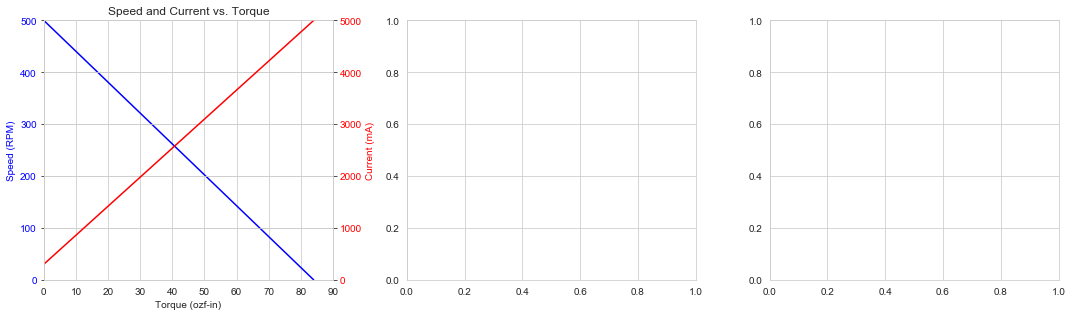

In [43]:
no_load_speed = 500
no_load_current = 300
stall_current = 5000
stall_torque = 84

torques = np.linspace(0, stall_torque)
speeds = torques * (-no_load_speed / stall_torque) + no_load_speed
currents = torques * ((stall_current - no_load_current) / stall_torque) + no_load_current
input_powers

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,4.5))

color = 'b'
ax1.plot(torques, speeds, color=color)
ax1.set(title='Speed and Current vs. Torque',
        xlabel='Torque (ozf-in)', xlim=[0, 90],
        ylabel='Speed (RPM)', ylim=[0, no_load_speed])
ax1.yaxis.label.set_color(color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'r'
ax1b = ax1.twinx()
ax1b.plot(torques, currents, color=color)
ax1b.set(ylabel='Current (mA)', ylim=[0, stall_current])
ax1b.yaxis.label.set_color(color)
ax1b.tick_params(axis='y', labelcolor=color)

# color = 'b'

# ax2.set(title="Input and Output Power vs. Torque",
#         xlabel='Torque (ozf-in)', xlim=[0, 90],
#         ylabel="Output Power (W)", ylim=[0, 10])
# ax2.yaxis.label.set_color(color)
# ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()